# Regression with an Abalone Dataset 鲍鱼数据集的回归

In [1]:
import pandas as pd
import numpy as np

import xgboost
import lightgbm
import optuna
import catboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### PROJECT DESCRIPTION

Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope

#### PHYSICAL ATTRIBUTES

**SEX**: Male/Female/Infant  
**LENGTH**: Longest shell measurement  
**DIAMETER**: Diameter of the Abalone  
**HEIGHT**: Height of the Abalone  
**WHOLE WEIGHT**: Weight of the whole abalone  
**SHUCKED WEIGHT**: Weight of the meat  
**VISCERA WEIGHT**: Gut Weight - Interal Organs  
**SHELL WEIGHT**: Shell Weight after drying  
**RINGS**: Number of rings +1.5 gives Age of the Abalone  

### 项目介绍

通过物理测量预测鲍鱼的年龄。 鲍鱼的年龄是通过将鲍鱼壳从锥体上切开、染色并通过显微镜计算环数来确定的。

#### 物理属性

**性别**：男/女/婴儿  
**长度**：最长外壳测量值  
**直径**：鲍鱼的直径  
**高度**：鲍鱼的高度  
**整体重量**：整个鲍鱼的重量  
**去壳重量**：肉的重量  
**内脏重量**：肠道重量 - 内脏器官  
**壳重**：干燥后的壳重  
**环**：环数+1.5给出鲍鱼的年龄  

# Load the Datasets 加载数据集

In [2]:
original = pd.read_csv("/kaggle/input/abalone-dataset/abalone.csv")
train = pd.read_csv("/kaggle/input/playground-series-s4e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")
# original = pd.read_csv("./data/abalone.csv")
# train = pd.read_csv("./data/train.csv")
# test = pd.read_csv("./data/test.csv")

## Make the data ready for tuning 准备好数据进行调整

In [3]:
train = train.drop("id", axis=1)
train=train.rename(columns={'Whole weight':'Whole weight','Whole weight.1':'Shucked weight', 'Whole weight.2':'Viscera weight', 'Shell weight':'Shell weight'})
test=test.rename(columns={'Whole weight':'Whole weight','Whole weight.1':'Shucked weight', 'Whole weight.2':'Viscera weight', 'Shell weight':'Shell weight'})

In [4]:
train = pd.concat([train, original], axis=0)

# Get familier with the Data 熟悉数据

In [5]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [6]:
print(f"The shape of training dataset is : {train.shape}")
print(f"The shape of testing dataset is : {test.shape}")

The shape of training dataset is : (94792, 9)
The shape of testing dataset is : (60411, 9)


In [7]:
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [8]:
train.groupby("Sex").count()["Length"]

Sex
F    27802
I    34435
M    32555
Name: Length, dtype: int64

In [9]:
test.groupby("Sex").count()["Length"]

Sex
F    17387
I    22241
M    20783
Name: Length, dtype: int64

In [10]:
np.sort(pd.unique(train.Rings))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

## View the Distribution 查看分布

(0.0, 1.0, 0.0, 1.0)

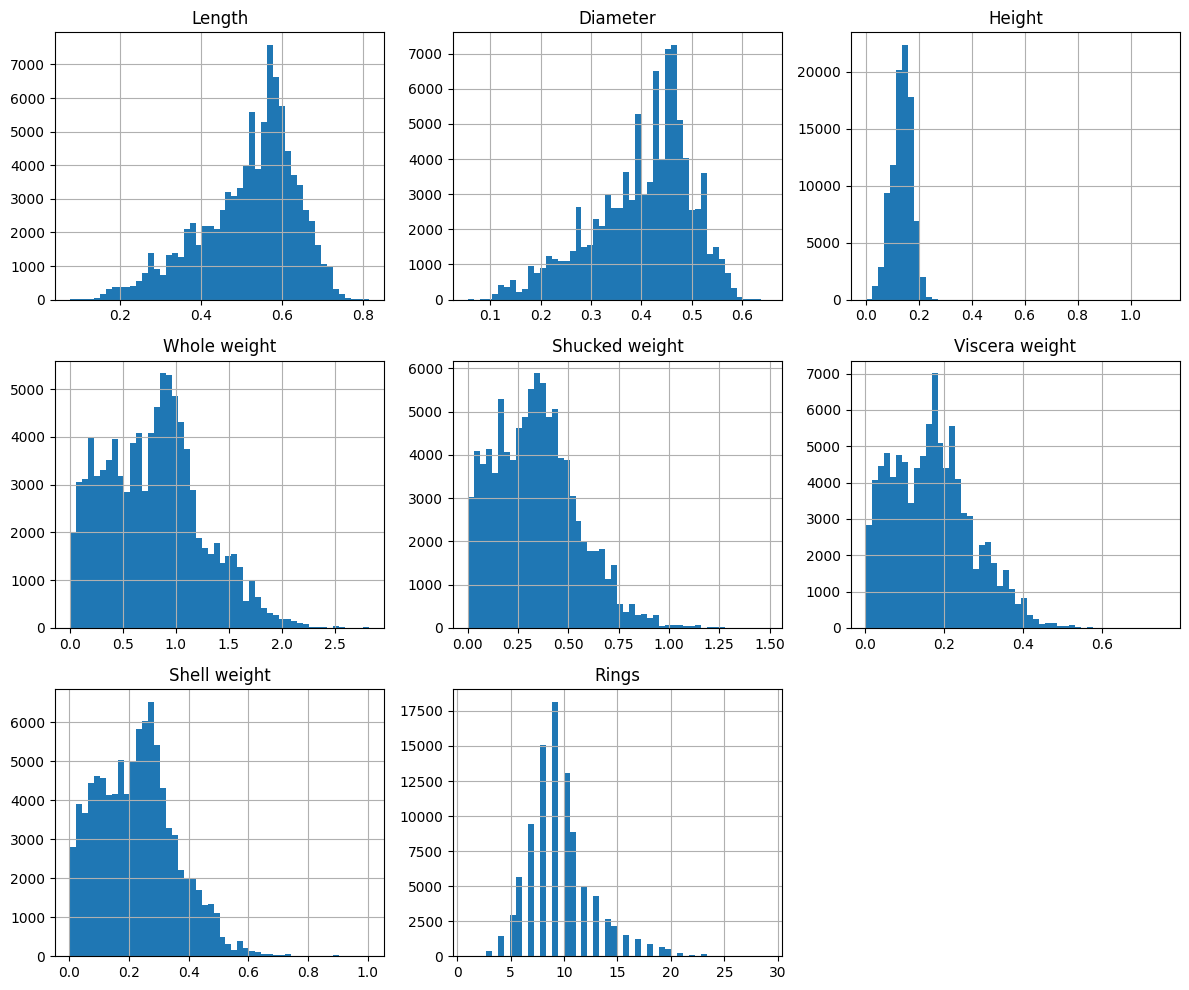

In [11]:
train.hist(figsize=(12, 10), grid=True, bins=50)
plt.tight_layout()
plt.axis("off")

(0.0, 1.0, 0.0, 1.0)

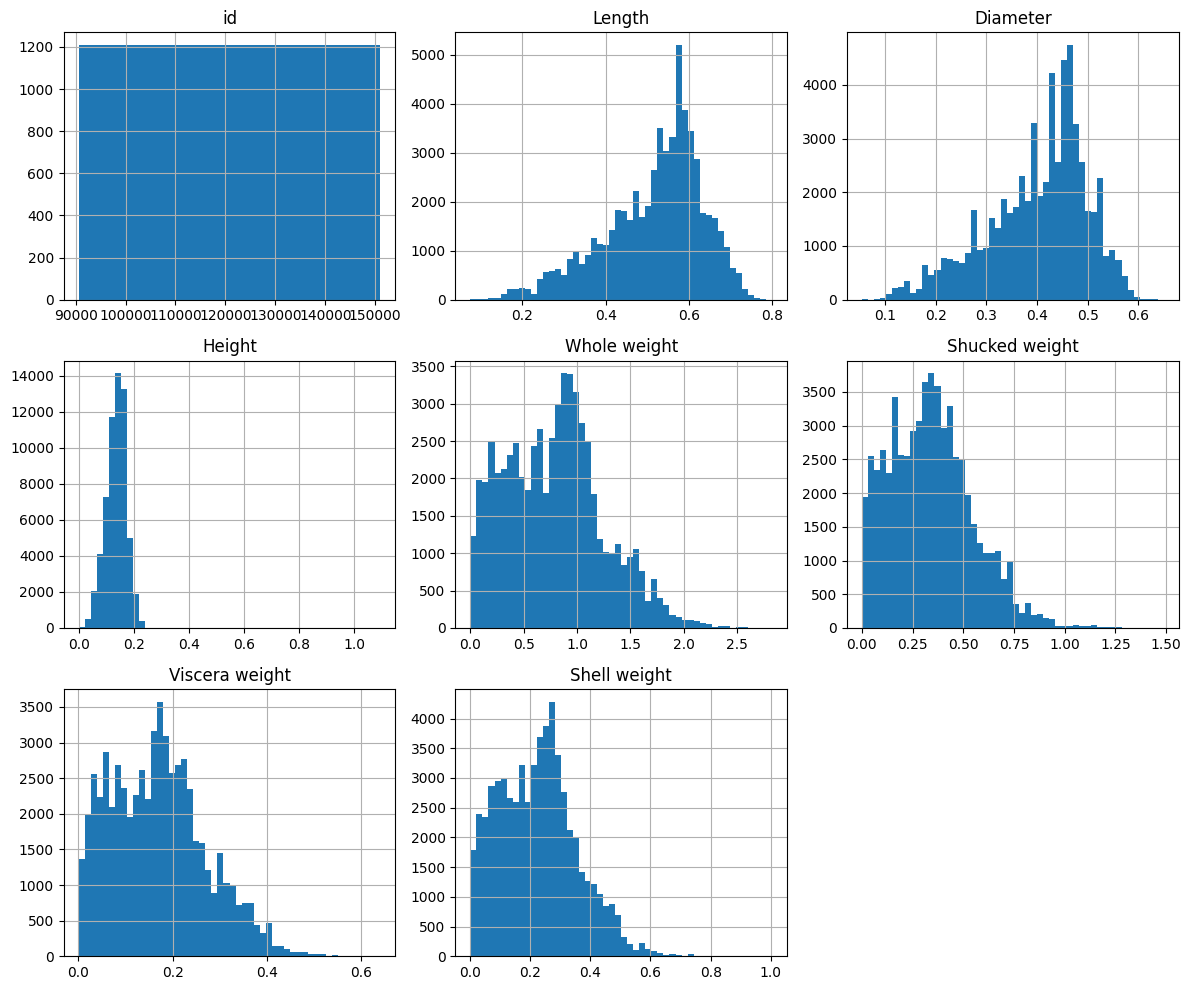

In [12]:
test.hist(figsize=(12, 10), grid=True, bins=50)
plt.tight_layout()
plt.axis("off")

CONTINUOUS COLUMN ANALYSIS 连续柱分析

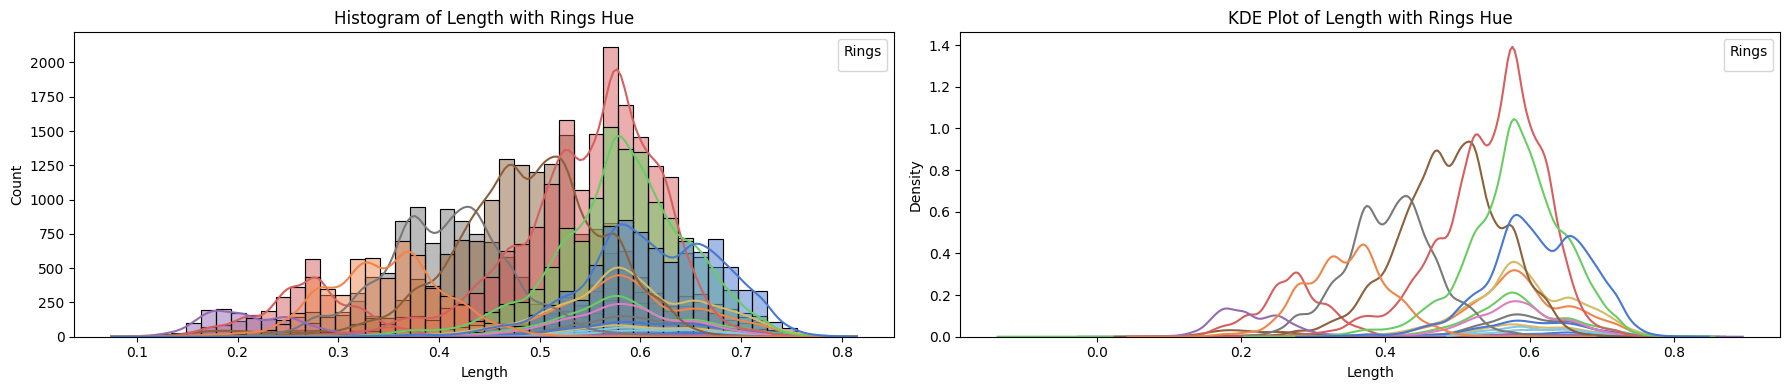

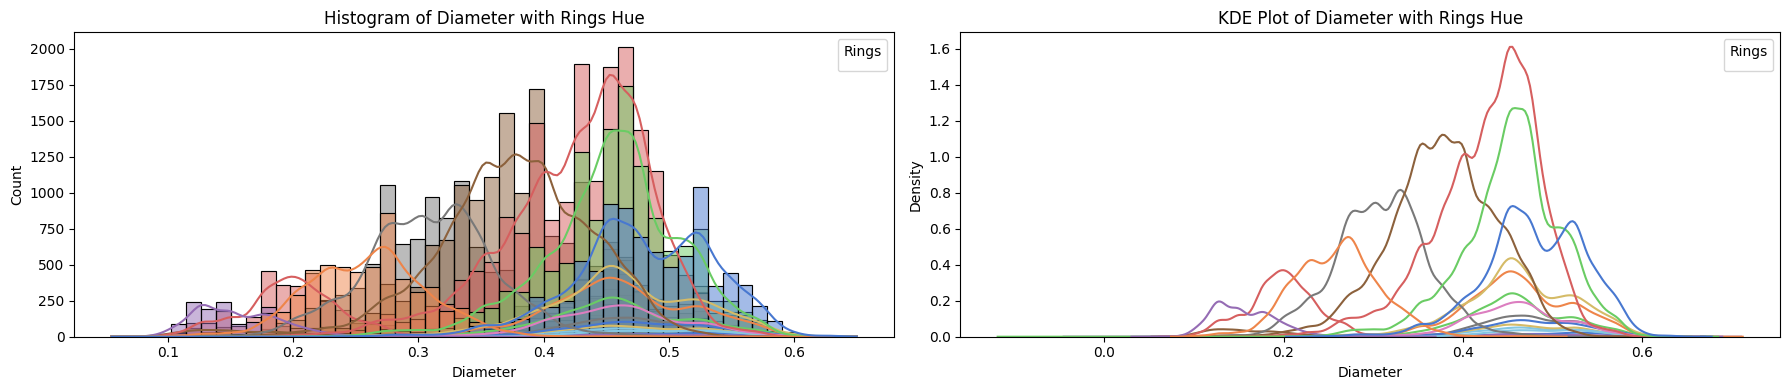

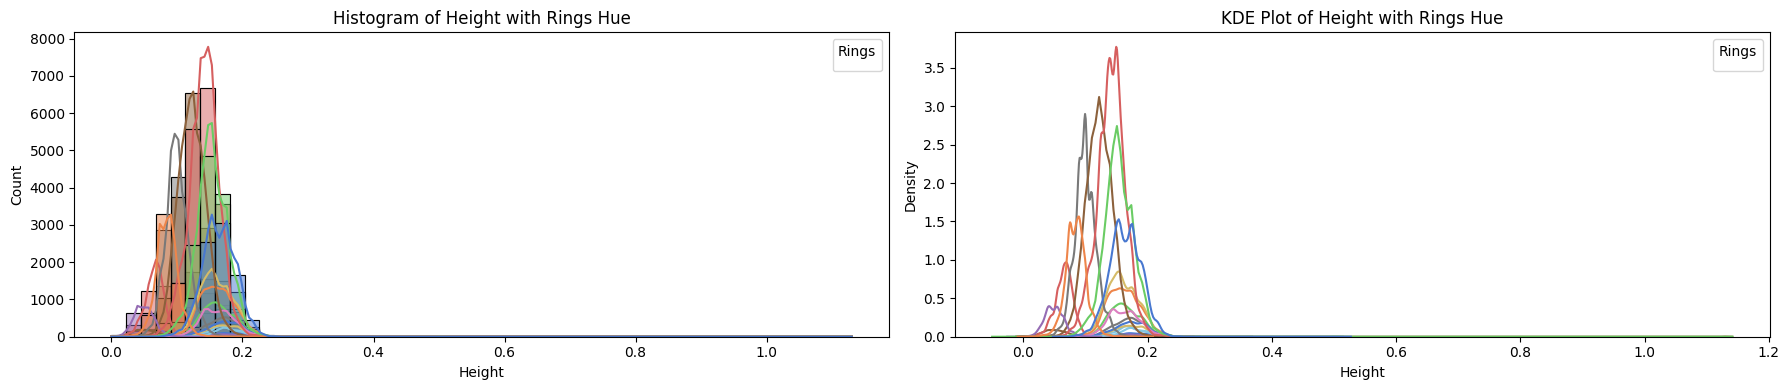

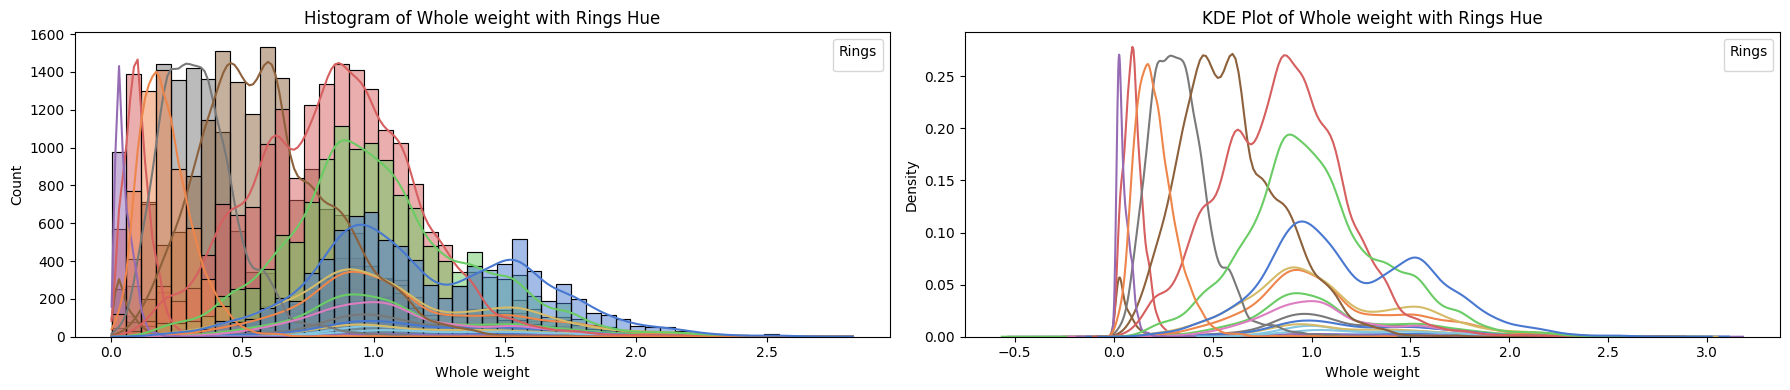

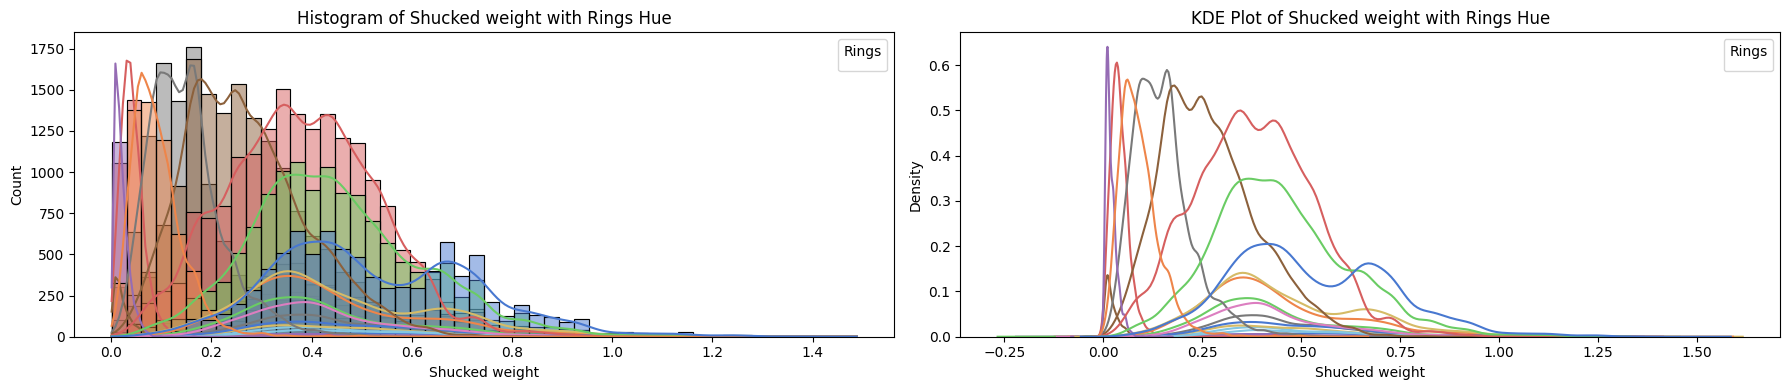

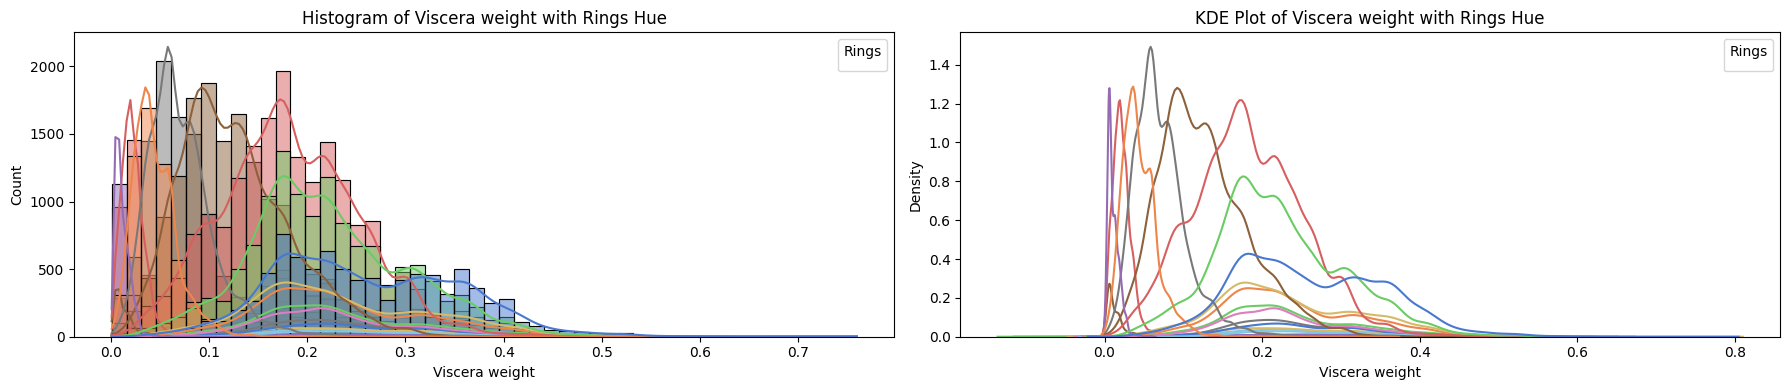

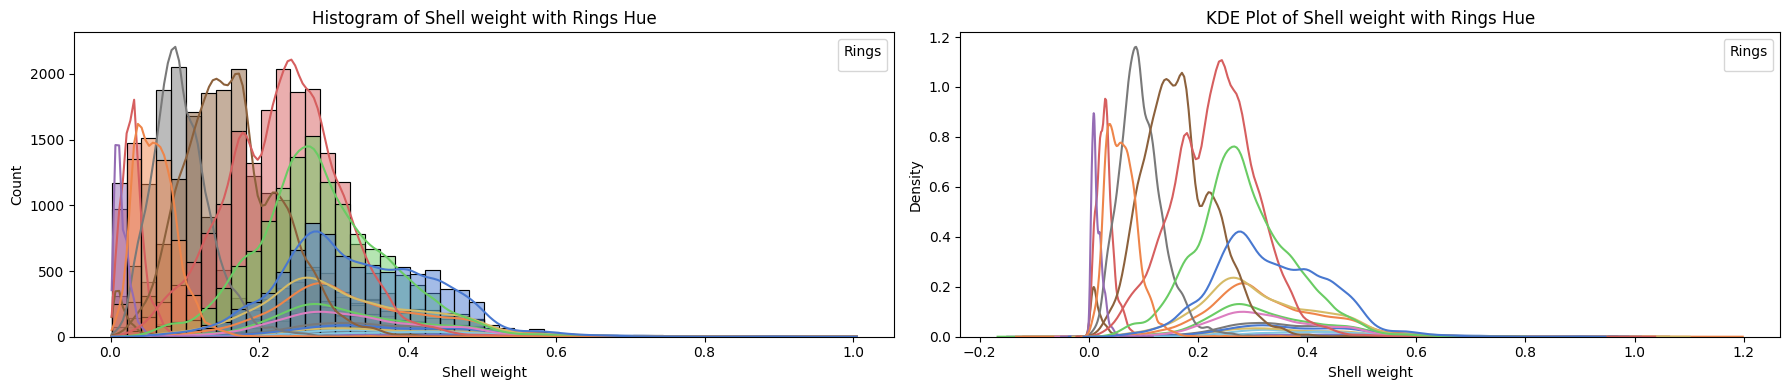

In [13]:
# Set up warnings to be ignored (optional)
warnings.filterwarnings("ignore")
pd.set_option('mode.use_inf_as_na', False)

train_str = train
train_str['Rings'] = train_str['Rings'].astype(str)

# List of continuous variables in your dataset
continuous_vars = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']

# Set hue to your target column
target_column = 'Rings'

for column in continuous_vars:
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))  # Create subplots with 1 row and 2 columns
    
    # Plot histogram with hue and explicit labels
    sns.histplot(data=train_str, x=column, hue=target_column, bins=50, kde=True, ax=axes[0], palette='muted', legend=False)
    axes[0].set_title(f'Histogram of {column} with {target_column} Hue')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].legend(title=target_column, loc='upper right')

    # Plot KDE plot with hue and explicit labels
    sns.kdeplot(data=train_str, x=column, hue=target_column, ax=axes[1], palette='muted', legend=False)
    axes[1].set_title(f'KDE Plot of {column} with {target_column} Hue')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Density')
    axes[1].legend(title=target_column, loc='upper right')
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

ANALYSIS BY QQ PLOT QQ图分析

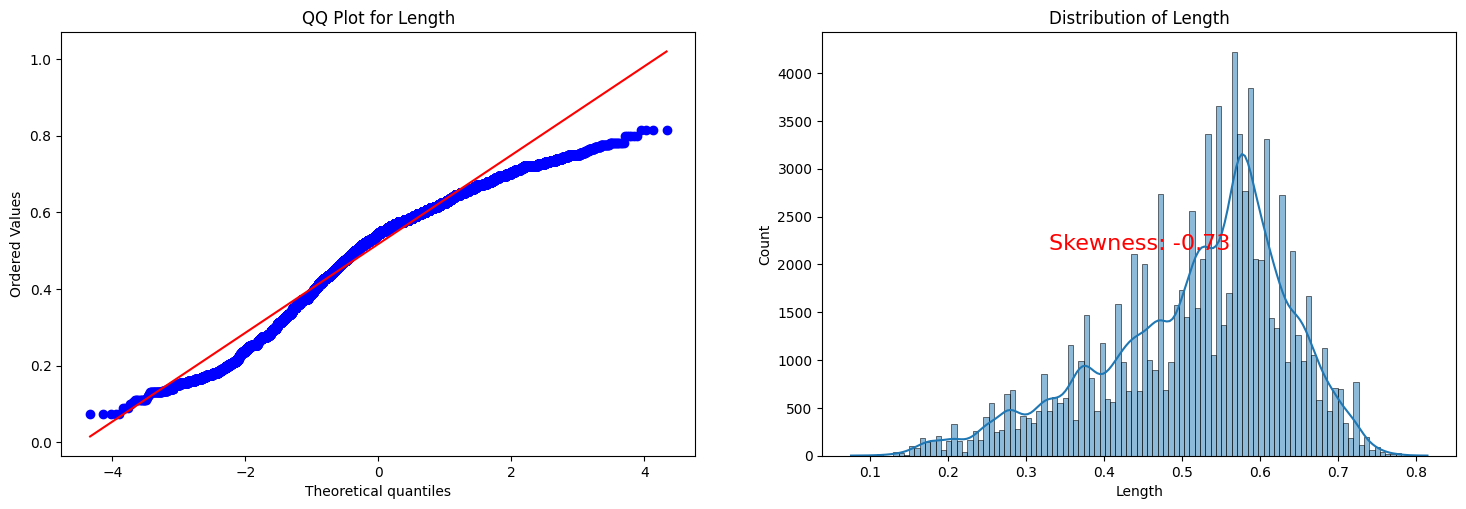

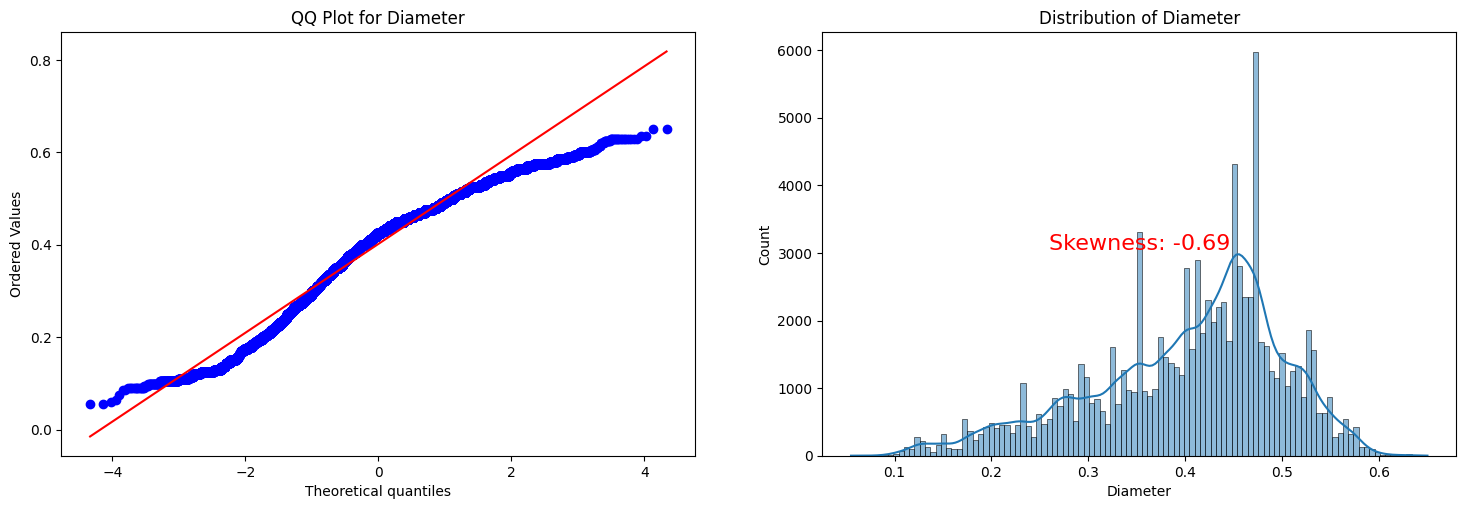

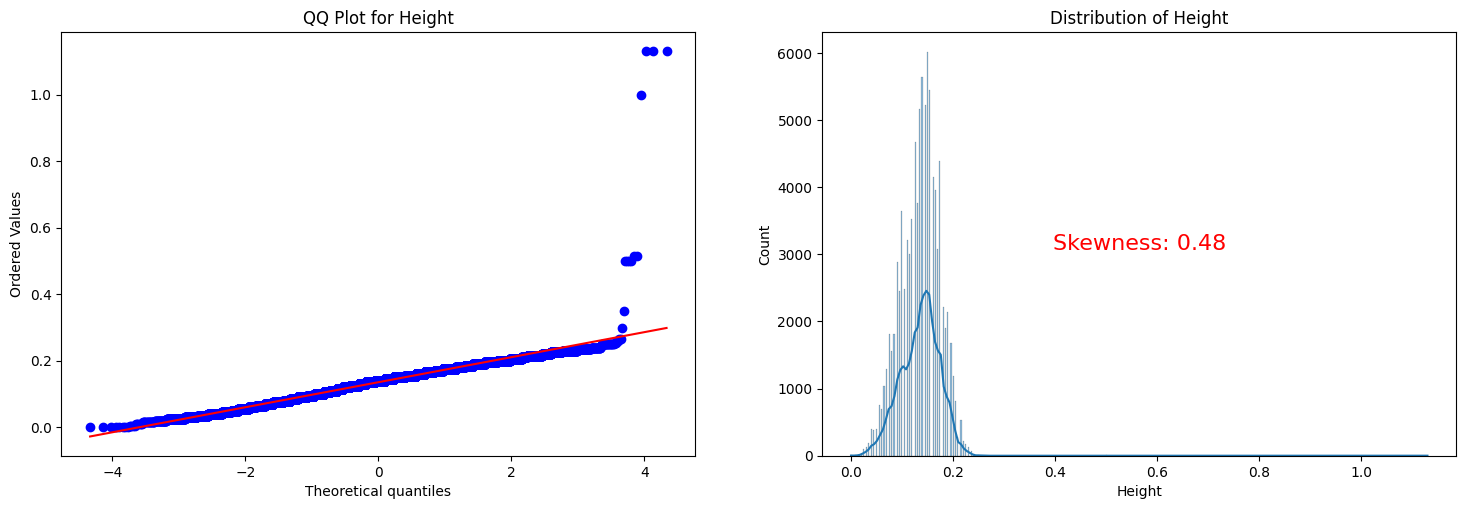

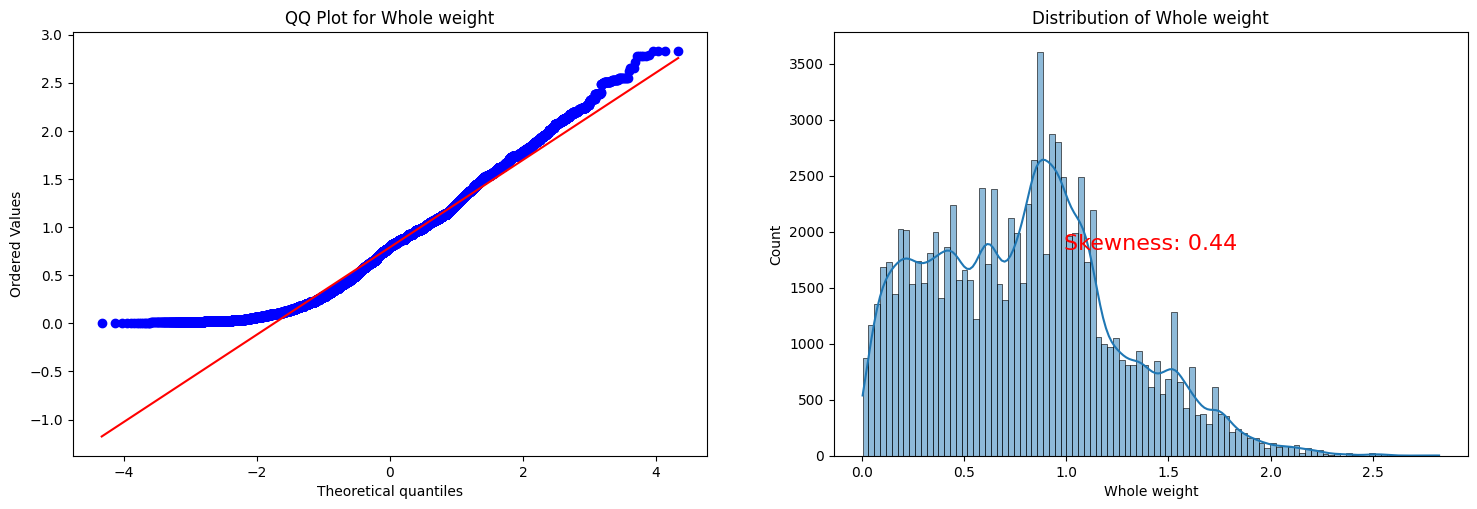

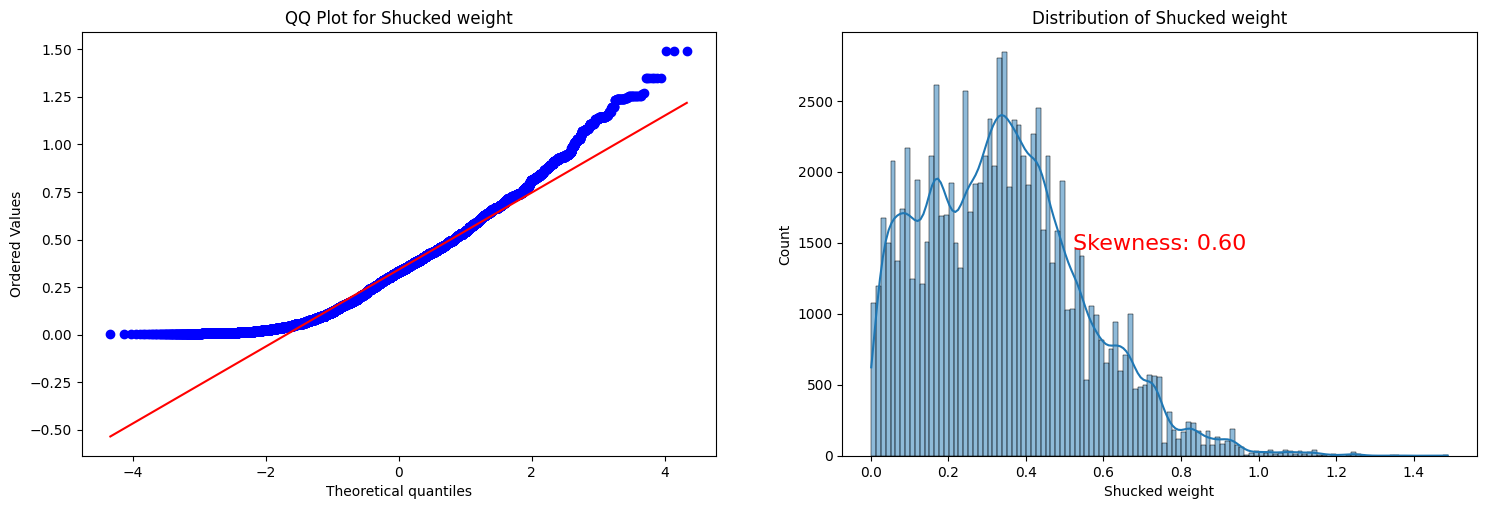

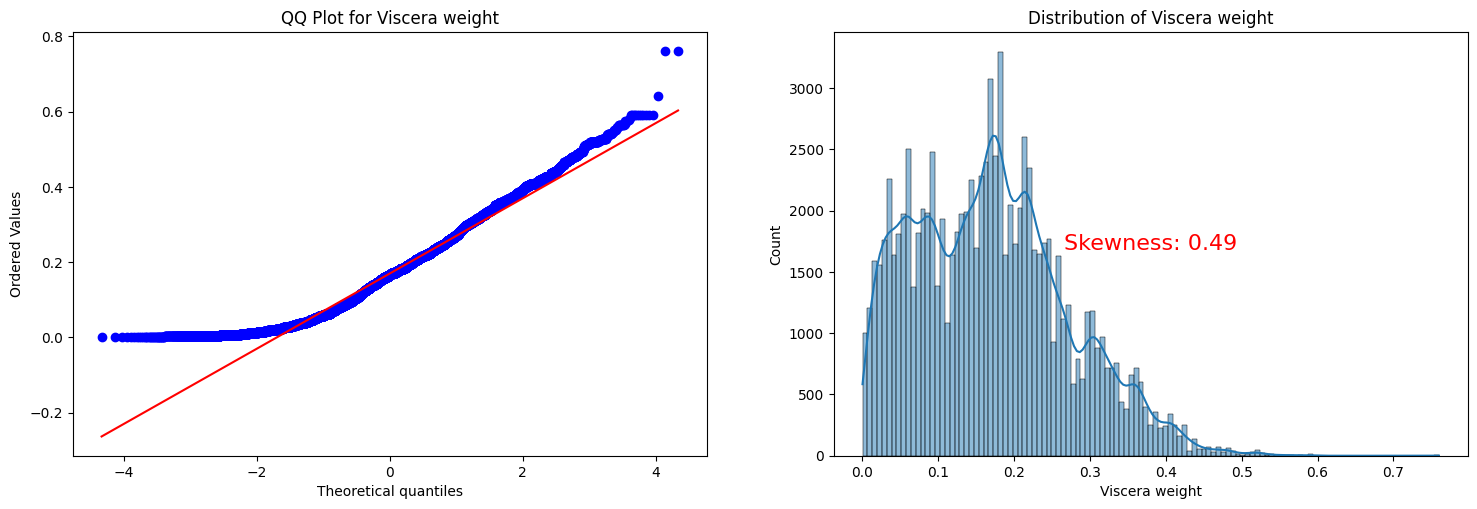

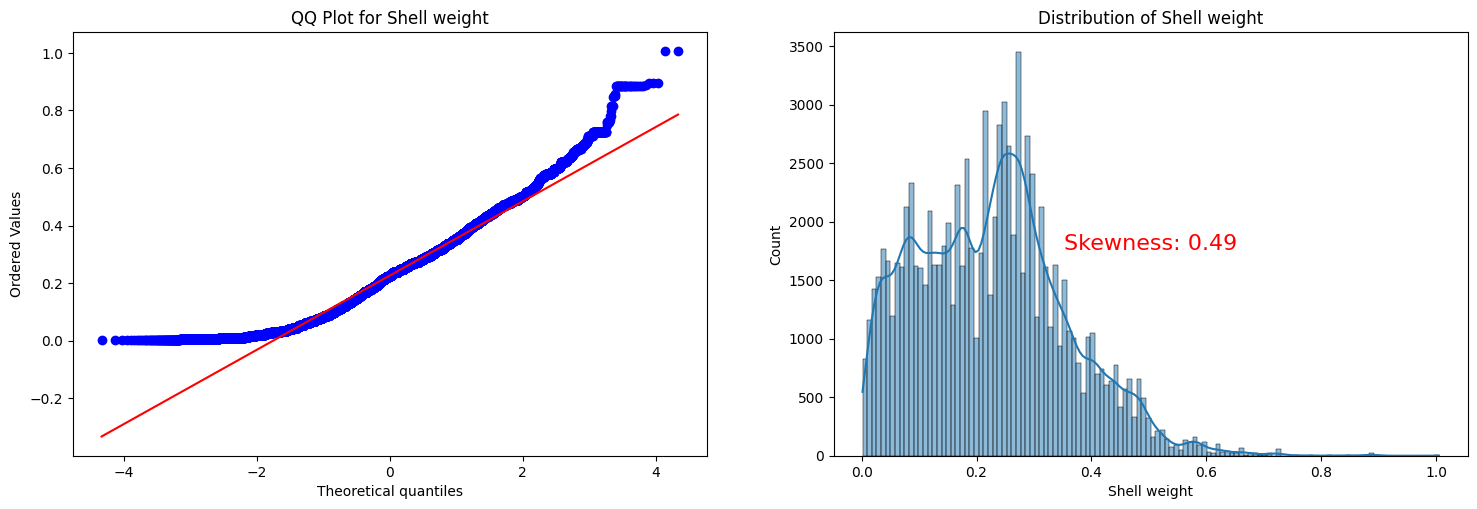

In [14]:
import scipy.stats as stats  
def qq_plot_with_skewness(data, quantitative_var):
    # Check if the variable is present in the DataFrame
    if quantitative_var not in data.columns:
        print(f"Error: '{quantitative_var}' not found in the DataFrame.")
        return
    
    f, ax = plt.subplots(1, 2, figsize=(18, 5.5))

    # Check for missing values
    if data[quantitative_var].isnull().any():
        print(f"Warning: '{quantitative_var}' contains missing values. Results may be affected.")

    # QQ plot
    stats.probplot(data[quantitative_var], plot=ax[0], fit=True)
    ax[0].set_title(f'QQ Plot for {quantitative_var}')

    # Skewness plot
    sns.histplot(data[quantitative_var], kde=True, ax=ax[1])
    ax[1].set_title(f'Distribution of {quantitative_var}')

    # Calculate skewness value
    skewness_value = stats.skew(data[quantitative_var])

    # Display skewness value on the plot
    ax[1].text(0.5, 0.5, f'Skewness: {skewness_value:.2f}', transform=ax[1].transAxes, 
               horizontalalignment='center', verticalalignment='center', fontsize=16, color='red')

    plt.show()
# Example usage for each continuous variable
for var in continuous_vars:
    qq_plot_with_skewness(train, var)

# Split the Dataset 分割数据集

In [15]:
sex_to_num = {
    "M": 0,
    "F": 1,
    "I": 2
}

In [16]:
train["Sex"] = train["Sex"].replace(sex_to_num.keys(), [sex_to_num[key] for key in sex_to_num])
test["Sex"] = test["Sex"].replace(sex_to_num.keys(), [sex_to_num[key] for key in sex_to_num])

In [17]:
train.groupby("Sex").count()["Length"]

Sex
0    32555
1    27802
2    34435
Name: Length, dtype: int64

In [18]:
X = train.drop("Rings", axis=1)
y = train.Rings

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

Here **stratify** parameter keeps the ratio of Rings same all across the Dtaset

# XGBoost 
we will be implementing two XGBoost models

In [20]:
def xgb_objective(trial):
    params = {
        "eta": trial.suggest_float("eta", 0.01, 1.0),
        "gamma": 0.0,
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_weight": trial.suggest_float("min_child_weight", 1., 50.),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("lambda", 1.0, 100.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000)
    }
    
    xgb_reg = TransformedTargetRegressor(xgboost.XGBRegressor(**params, objective='reg:squarederror', grow_policy='lossguide',
                                                         tree_method="hist", random_state=42),
                                                         func=np.log1p,
                                                         inverse_func=np.expm1)
    xgb_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    
    val_scores = mean_squared_log_error(y_valid, xgb_reg.predict(X_valid), squared=False)
    return val_scores

sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization
xgb_study = optuna.create_study(direction = 'minimize',study_name="XgbRegressor", sampler=sampler)

[I 2024-04-25 08:54:23,101] A new study created in memory with name: XgbRegressor


### XGBoost 1st model

In [21]:
TUNE = False
if TUNE:
    xgb_study.optimize(xgb_objective, n_trials=500)

Set **TUNE** parameter to **True** incase you want to run Hyper Parameter Tuning

In [22]:
xgb_best_params_1 = {
    'eta': 0.1006321838798394,
    'max_depth': 6,
    'min_child_weight': 27.999752791085136,
    'subsample': 0.7344797943645852,
    'colsample_bytree': 0.5389765810810496,
    'lambda': 79.62358968148187,
    'n_estimators': 407
}

In [23]:
xgb_reg_1 = TransformedTargetRegressor(xgboost.XGBRegressor(**xgb_best_params_1, objective='reg:squarederror', grow_policy='lossguide',
                                                 tree_method="hist", random_state=42, gamma=0.0),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [24]:
xgb_reg_1.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.5389765810810496,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eta=0.1006321838798394,
                                                  eval_metric=None,
                                                  feature_types=None, gamm...
                                                  grow_policy='lossguide',
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  lambda=79.62358968148187,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=6, max_leaves=None,
                                                  min_child_weight=27.999752791085136,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=407, n_jobs=None, ...))

In [25]:
mean_squared_log_error(y_valid, xgb_reg_1.predict(X_valid), squared=False)

0.14869597187974176

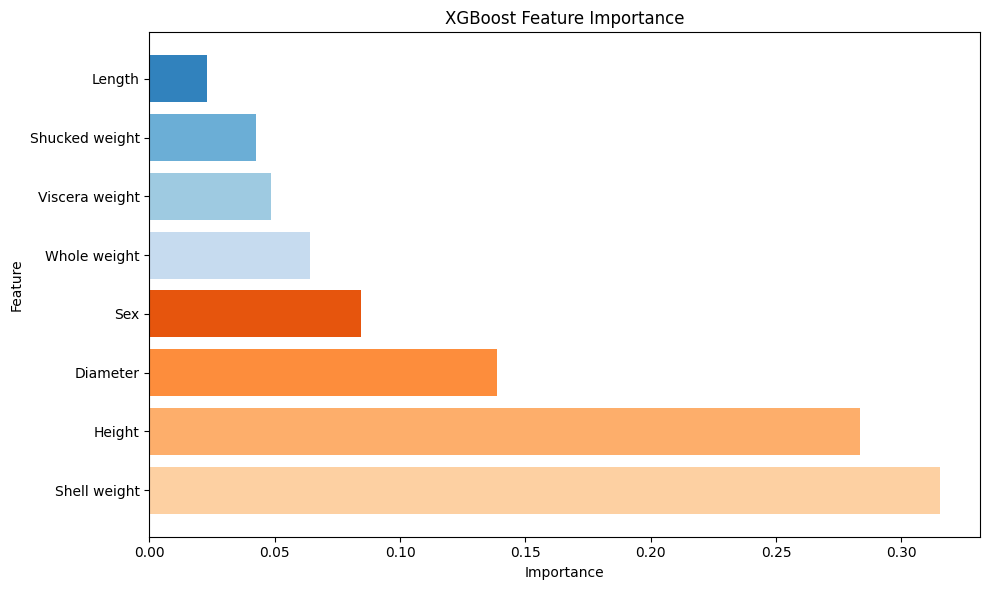

In [26]:
feature_importance = xgb_reg_1.regressor_.feature_importances_
feature_names = X_train.columns

sorted_indices = feature_importance.argsort()
sorted_importance = feature_importance[sorted_indices]
sorted_features = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20c.colors[:len(sorted_features)]  
plt.barh(sorted_features, sorted_importance, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis() 
plt.tight_layout()  
plt.show()

### XGBoost 2

In [27]:
xgb_best_params_2 = {
    'eta': 0.08999645298052271,
    'max_depth': 6,
    'min_child_weight': 2.088127882610971,
    'subsample': 0.7725806961689413,
    'colsample_bytree': 0.9163306027660207,
    'lambda': 5.356530752285997,
    'n_estimators': 652
}

In [28]:
xgb_reg_2 = TransformedTargetRegressor(xgboost.XGBRegressor(**xgb_best_params_2, objective='reg:squaredlogerror', grow_policy='depthwise',
                                                          tree_method="hist", random_state=42),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [29]:
xgb_reg_2.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.9163306027660207,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eta=0.08999645298052271,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gam...
                                                  grow_policy='depthwise',
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  lambda=5.356530752285997,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=6, max_leaves=None,
                                                  min_child_weight=2.088127882610971,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=652, n_jobs=None, ...))

In [30]:
mean_squared_log_error(y_valid, xgb_reg_2.predict(X_valid), squared=False)

0.14859960794386676

# LIGHTGBM

In [31]:
def lgbm_objective(trial):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "verbosity": -1,
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 70),
        "num_leaves": trial.suggest_int("num_leaves", 30, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.1, 1.0)
    }

    lgbm_reg = lightgbm.LGBMRegressor(**param)
    
    lgbm_reg.fit(X_train, y_train)

    score = mean_squared_log_error(y_valid, lgbm_reg.predict(X_valid), squared=False)

    return score


# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
lgbm_study = optuna.create_study(direction="minimize", sampler=sampler)

[I 2024-04-25 08:54:30,842] A new study created in memory with name: no-name-14dd5a7a-d849-431d-af7a-76e0faf6010a


In [32]:
if TUNE:
    # Run the optimization process
    lgbm_study.optimize(lambda trial: lgbm_objective(trial), n_trials=200)

    # Get the best parameters after optimization
    lgbm_best_params = lgbm_study.best_params

    print('='*50)
    print(lgbm_best_params)

### LIGHTGbm 1

In [33]:
lgbm_params_1 = {
    'learning_rate': 0.04090453688322824,
    'n_estimators': 788,
    'reg_lambda': 29.248167932522765,
    'reg_alpha': 0.4583079398945705,
    'max_depth': 19,
    'colsample_bytree': 0.5439642175304692,
    'subsample': 0.8659762900446526,
    'min_child_samples': 12,
    'num_leaves': 69,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

In [34]:
lgbm_reg_1 = TransformedTargetRegressor(lightgbm.LGBMRegressor(**lgbm_params_1),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [35]:
lgbm_reg_1.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LGBMRegressor(colsample_bytree=0.5439642175304692,
                                                   learning_rate=0.04090453688322824,
                                                   max_depth=19,
                                                   min_child_samples=12,
                                                   n_estimators=788, n_jobs=-1,
                                                   num_leaves=69,
                                                   random_state=42,
                                                   reg_alpha=0.4583079398945705,
                                                   reg_lambda=29.248167932522765,
                                                   subsample=0.8659762900446526,
                                                   verbose=-1))

In [36]:
mean_squared_log_error(y_valid, lgbm_reg_1.predict(X_valid), squared=False)

0.14773813058854993

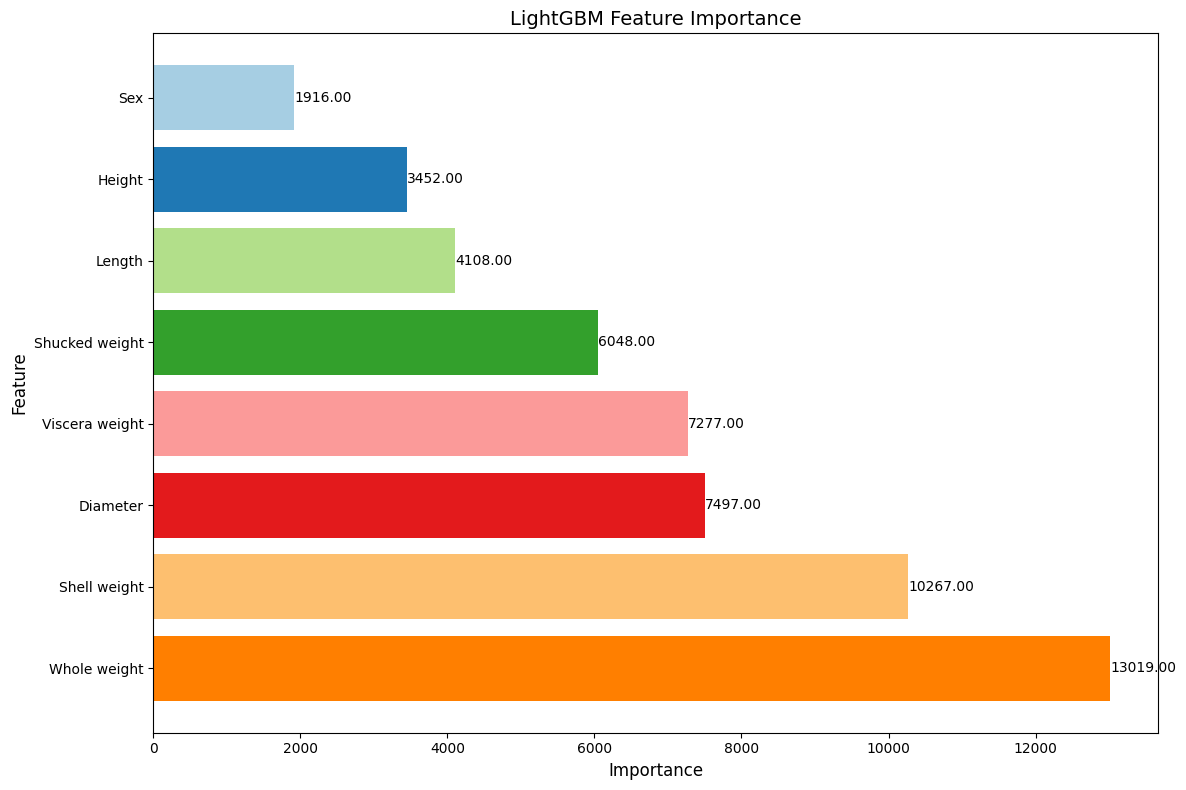

In [37]:
feature_importance = lgbm_reg_1.regressor_.feature_importances_

feature_names = X_train.columns

sorted_indices = feature_importance.argsort()
sorted_importance = feature_importance[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(12, 8))
colors = plt.cm.Paired.colors[:len(sorted_features)]  
plt.barh(sorted_features, sorted_importance, color=colors)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('LightGBM Feature Importance', fontsize=14)
plt.gca().invert_yaxis() 

for i, v in enumerate(sorted_importance):
    plt.text(v + 0.02, i, f'{v:.2f}', color='black', va='center', fontsize=10)

plt.tight_layout()  
plt.show()

### LIGHTGbm 2

In [38]:
lgbm_params_2 = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 20,
    'num_leaves': 165,
    'subsample_freq': 1,
    'random_state': 42,
    'n_estimators': 1460,
    'min_child_samples': 25,
    'reg_lambda': 6.13475387151606,
    'subsample': 0.8036874216939632,
    'reg_alpha': 0.3152990674231573,
    'learning_rate': 0.009336479469693189,
    'colsample_bytree': 0.5780931837049811,
    'min_child_weight': 0.37333232256934057,
}

In [39]:
lgbm_reg_2 = TransformedTargetRegressor(lightgbm.LGBMRegressor(**lgbm_params_2),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [40]:
lgbm_reg_2.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LGBMRegressor(colsample_bytree=0.5780931837049811,
                                                   learning_rate=0.009336479469693189,
                                                   max_depth=20,
                                                   min_child_samples=25,
                                                   min_child_weight=0.37333232256934057,
                                                   n_estimators=1460, n_jobs=-1,
                                                   num_leaves=165,
                                                   random_state=42,
                                                   reg_alpha=0.3152990674231573,
                                                   reg_lambda=6.13475387151606,
                                                   subsample=0.8036874216939632,
                                                   subsample_freq=1,
                                                   verbose=-1))

In [41]:
mean_squared_log_error(y_valid, lgbm_reg_2.predict(X_valid), squared=False)

0.14758741259851116

# CatBoost

In [42]:
def cb_objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "max_depth": trial.suggest_int("depth", 4, 16),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
    }
    
    cb_reg = TransformedTargetRegressor(catboost.CatBoostRegressor(**params, random_state=42, grow_policy='SymmetricTree',
                                                                  random_strength=0, cat_features=["Sex"], loss_function="RMSE"),
                                                     func=np.log1p,
                                                     inverse_func=np.expm1)
    cb_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    
    val_scores = np.sqrt(mean_squared_log_error(y_valid, np.abs(cb_reg.predict(X_valid))))
    return val_scores

sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization
cb_study = optuna.create_study(direction = 'minimize',study_name="CBRegressor", sampler=sampler)

[I 2024-04-25 08:55:12,972] A new study created in memory with name: CBRegressor


In [43]:
if TUNE:
    cb_study.optimize(cb_objective, 30)

### CatBoost 1

In [44]:
cb_params_1 = {
    'grow_policy': 'SymmetricTree', 
    'n_estimators': 1000, 
    'learning_rate': 0.128912681527133, 
    'l2_leaf_reg': 1.836927907521674, 
    'max_depth': 6, 
    'colsample_bylevel': 0.6775373040510968, 
    'random_strength': 0, 
    'boost_from_average': True, 
    'loss_function': 'RMSE', 
    'cat_features': ['Sex'], 
    'verbose': False
    }

In [45]:
cat_reg_1 = TransformedTargetRegressor(catboost.CatBoostRegressor(**cb_params_1),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [46]:
cat_reg_1.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=<catboost.core.CatBoostRegressor object at 0x7de62d174bb0>)

In [47]:
mean_squared_log_error(y_valid, cat_reg_1.predict(X_valid), squared=False)

0.148248413722528

## CatBoost 2

In [48]:
cb_params_2 = {
    'depth': 15, 
    'verbose': 0,
    'max_bin': 464, 
    'verbose': False,
    'random_state':42,
    'task_type': 'CPU', 
    'random_state': 42,
    'min_data_in_leaf': 78, 
    'loss_function': 'RMSE', 
    'grow_policy': 'Lossguide', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.83862137638162, 
    'l2_leaf_reg': 8.365422739510098, 
    'random_strength': 3.296124856352495, 
    'learning_rate': 0.09992185242598203,
}

In [49]:
cat_reg_2 = TransformedTargetRegressor(catboost.CatBoostRegressor(**cb_params_2),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [50]:
cat_reg_2.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=<catboost.core.CatBoostRegressor object at 0x7de636432470>)

In [51]:
mean_squared_log_error(y_valid, cat_reg_2.predict(X_valid), squared=False)

0.14774083919007364

# Ensembling the Results Using VotingRegressor 使用 VotingRegressor 组合结果

In [52]:
# weights = [0.025, 0.025, 0.275, 0.275, 0.05, 0.35]

ensemble = VotingRegressor(
    [
#         ("xgb_1", xgb_reg_1),
#         ("xgb_2", xgb_reg_2),
        ("lgbm_1", lgbm_reg_1),
        ("lgbm_2", lgbm_reg_2),
        ("cb_1", cat_reg_1),
        ("cb_2", cat_reg_2)
    ]
)

In [53]:
ensemble.fit(X, y)

VotingRegressor(estimators=[('lgbm_1',
                             TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=LGBMRegressor(colsample_bytree=0.5439642175304692,
                                                                                learning_rate=0.04090453688322824,
                                                                                max_depth=19,
                                                                                min_child_samples=12,
                                                                                n_estimators=788,
                                                                                n_jobs=-1,
                                                                                num_leaves=69,
                                                                                random_state=42,
                                                                                reg_alpha=0.4583079398945705,
                                                                                reg_lambda=29.248167932...
                                                                                subsample=0.8036874216939632,
                                                                                subsample_freq=1,
                                                                                verbose=-1))),
                            ('cb_1',
                             TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=<catboost.core.CatBoostRegressor object at 0x7de62d174bb0>)),
                            ('cb_2',
                             TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=<catboost.core.CatBoostRegressor object at 0x7de636432470>))])

# Submit the Output

In [54]:
pred = ensemble.predict(test.drop("id", axis=1))

In [55]:
submission = pd.DataFrame(test.id)

In [56]:
submission["Rings"] = pred

In [57]:
submission.to_csv("submission.csv", index=False)